
# Trabalho 2 - Tópicos em IA 
## (**Parte 2**)

### Realizando Predições e Visualizando Métricas
---


## Introdução

Neste ponto, os modelos foram treinados e estão salvos em `/documents/bertimbau-(baseline | alternativo)-cls-ptbr`

Vamos carregá-los, realizar as predições e visualizar métricas

**Observação**: Para realizar as predições, precisamos do `test_dataset`, que criamos na primeira parte do trabalho.

Para isso, podemos replicar o código aqui, ou salvar e pegar apenas ele. Salvei na pasta documents, que contém o corpus de notícias e os modelos. Para replicar este notebook, os passos do notebook anterior devem ser replicados desde o começo, e o corpus de notícia deve estar corretamente rastreado (ou, quem sabe, no futuro, pegar o modelo direto do meu hugging face).


---

## Configs Iniciais

#### configurações iniciais do path

In [20]:

import os, sys
root = os.path.abspath('../')
src_path = os.path.join(root, 'src')
sys.path.append(root)

#### imports

In [21]:
from safetensors.torch import load_file
from torch import load as t_load
import torch

from src.custom_bertimbau_classifier import CustomBertimbauClassifier
from src.baseline_bertimbau_classifier import BaselineBertimbauClassifier
from src.dataset_loader import DatasetLoader, FakeNewsDataset
import src.config as cfg

import numpy as np
import random
import evaluate

from transformers import (
    BertForSequenceClassification,
    Trainer, TrainingArguments,
    PreTrainedTokenizerFast
    )

In [22]:
#para os gráficos
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.manifold import TSNE
import torch


#### algumas funções simples para simplificar o script

In [23]:

get_checkpoint_dir = lambda base_alt: os.path.join(root,"documents",f"bertimbau-{base_alt}-cls-ptbr","checkpoint-630") 
get_state_dict = lambda base_alt: load_file(os.path.join(get_checkpoint_dir(base_alt),"model.safetensors")) 

# print(type(get_checkpoint_dir("baseline")))

#### tornando as libs determinísticas

In [24]:
#physics are relative, but this code gonna be DETERMINISTIC BABY! (sim, copiei do main.ipynb)
random.seed(cfg.RANDOM_SEED) 
np.random.seed(cfg.RANDOM_SEED) 
torch.manual_seed(cfg.RANDOM_SEED)

torch.backends.cudnn.deterministic = True

## Carregando Trainer e Dataset para Predição

### Compute Metrics

Devemos trazer de volta a função customizada de computar métricas

In [25]:
acc_metric = evaluate.load("accuracy")
prec_metric = evaluate.load("precision")
rec_metric = evaluate.load("recall")
f1_metric = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    
    return {
        "accuracy": acc_metric.compute(predictions=preds, references=labels)["accuracy"],
        "precision": prec_metric.compute(predictions=preds, references=labels, average="macro")["precision"],
        "recall": rec_metric.compute(predictions=preds, references=labels, average="macro")["recall"],
        "f1": f1_metric.compute(predictions=preds, references=labels, average="macro")["f1"]
    }


### Load do Dataset para Testes

#### load de `test_dataset`
Reproduzindo o código que processa o dataset de notícias...

Este código é interessante pois traz todos os datasets, o tokenizer e os kwargs do `BertForSequenceClassification` são facilmente recuperados.

Porém, existe uma forma alternativa de capturar o dataset e o tokenizer, através dos arquivos `tokenizer.json` e, caso criado, `test_dataset.pkl`

Para o dataset, criei das duas formas, para fins demosntrativos. O mesmo quanto ao tokenizer 

In [26]:
def get_test_dataset_normal():
    path = os.path.join(root, cfg.PATH_TO_DATASET)
    ds_loader = DatasetLoader(
        path=path,
        model_name=cfg.BERTIMBAU,
        max_len=cfg.SEQ_LEN
    )

    #conjunto para teste, validação e treino
    _, _, test_dataset = (ds_loader
                            .load_dataset(seed=cfg.RANDOM_SEED)
                            .get_datasets())

    print(len(test_dataset))

    return test_dataset

#### load de `test_dataset` (_método diferenciado_)

Alternativamente, é possível poupar retrabalho. Tendo setado `salvar_test_dataset = True` no último bloco de código da seção "Carregando o Dataset de Notícias", no fluxo do notebook principal, temos o arquivo `test_dataset.pkl` salvo em documents. Para extraí-lo, basta utilizar a biblioteca `pickle`



In [ ]:
import pickle
def get_test_dataset_diferenciado():
    #é necessário ter o tipo do objeto carregado pelo pickle presente no código.
    test_dataset_path = os.path.join(root, "documents", "test_dataset.pkl")

    with open(test_dataset_path, 'rb') as ds:
        test_dataset = pickle.load(ds)


    print(type(test_dataset))
    return test_dataset

In [29]:
test_dataset = get_test_dataset_normal()

1080


### Load do Tokenizer

Aqui mostro as duas formas de capturar o tokenizer.

#### forma com o `ds_loader` carregado

(certifique-se de ter carregado o Dataset Loader para executar)

In [ ]:
# tokenizer = ds_loader.get_tokenizer()

#### _método diferenciado_: 
forma com `tokenizer.json` salvo devido a `save_strategy` em `TrainingArguments`

In [30]:
# tokenizer = PreTrainedTokenizerFast(tokenizer_file=os.path.join(get_checkpoint_dir("baseline"),"tokenizer.json"))
from transformers import AutoTokenizer, BertTokenizerFast

# tokenizer1 = AutoTokenizer.from_pretrained(get_checkpoint_dir("baseline"))
tokenizer = BertTokenizerFast.from_pretrained("neuralmind/bert-base-portuguese-cased")

### Load do Trainer
Para isso, aproveitaremos dos arquivos salvos devido à configuração `save_strategy`, de `TrainingArguments`

#### Trainer do Baseline

In [31]:
from transformers import TrainingArguments, Trainer

baseline_checkpoint_dir = get_checkpoint_dir("baseline")
baseline_model = BertForSequenceClassification.from_pretrained(
    baseline_checkpoint_dir
).to(cfg.DEVICE)

tokenizer = AutoTokenizer.from_pretrained("neuralmind/bert-base-portuguese-cased")

testing_args = TrainingArguments(
    output_dir="tmp_eval",
    per_device_eval_batch_size=cfg.BATCH_SIZE,
    do_train=False,
    do_eval=True,
    do_predict=True,
    report_to="none",
)

baseline_trainer = Trainer(
    model=baseline_model,
    tokenizer=tokenizer,
    args=testing_args,
    compute_metrics=compute_metrics,
)


C:\Users\mathe\AppData\Local\Temp\ipykernel_17064\144381261.py:19: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  baseline_trainer = Trainer(


In [32]:
print(baseline_checkpoint_dir)

c:\Users\mathe\OneDrive\Área de Trabalho\fake-news-detector\documents\bertimbau-baseline-cls-ptbr\checkpoint-630


#### Trainer do modelo alternativo

(lembrando, o tokenizer é o mesmo para as duas versões do modelo)

In [35]:
alt_checkpoint = get_checkpoint_dir("alternativo")
alt_training_args = t_load(os.path.join(alt_checkpoint, "training_args.bin"), weights_only=False)

assert tokenizer is not None

alt_model = CustomBertimbauClassifier() #carrega lá do hugging face, denovo

alt_state_dict = load_file(os.path.join(alt_checkpoint, "model.safetensors"))
alt_model.load_state_dict(alt_state_dict)
alt_model.to(cfg.DEVICE)
alt_model.eval()

alt_training_args.eval_strategy = "no"

alt_trainer = Trainer(
    alt_model,
    alt_training_args,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)



print("caminho pro checkpoint:", alt_checkpoint)
alt_trainer

caminho pro checkpoint: c:\Users\mathe\OneDrive\Área de Trabalho\fake-news-detector\documents\bertimbau-alternativo-cls-ptbr\checkpoint-630


C:\Users\mathe\AppData\Local\Temp\ipykernel_17064\1907372000.py:15: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  alt_trainer = Trainer(


## Realizando Predições

In [33]:
baseline_predictions = baseline_trainer.predict(test_dataset)


c:\Users\mathe\OneDrive\Área de Trabalho\fake-news-detector\.venv\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


In [36]:
alternative_predictions = alt_trainer.predict(test_dataset=test_dataset)

c:\Users\mathe\OneDrive\Área de Trabalho\fake-news-detector\.venv\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


## Visualizando **Métricas**

Sem muitos comentários, vou plotar os gráficos e as métricas no geral. Análise Crítica disponível no documento em PDF

### Métricas Gerais do Teste
Derivadas de Compute Metrics

#### baseline

In [38]:
baseline_predictions.metrics

{'test_loss': 0.19315305352210999,
 'test_model_preparation_time': 0.021,
 'test_accuracy': 0.9537037037037037,
 'test_precision': 0.9538593481989708,
 'test_recall': 0.9537037037037037,
 'test_f1': 0.9536997342021778,
 'test_runtime': 190.5836,
 'test_samples_per_second': 5.667,
 'test_steps_per_second': 0.357}

#### mean pooling

In [39]:
alternative_predictions.metrics

{'test_loss': 0.18827331066131592,
 'test_model_preparation_time': 0.0203,
 'test_accuracy': 0.9564814814814815,
 'test_precision': 0.9567461937817185,
 'test_recall': 0.9564814814814815,
 'test_f1': 0.9564751751582663,
 'test_runtime': 209.6017,
 'test_samples_per_second': 5.153,
 'test_steps_per_second': 0.324}

### Gráficos


#### 1. carregar histórico de treinamento


In [40]:

def load_training_history(checkpoint_dir):
    """Carrega trainer_state.json com histórico de loss e métricas"""
    with open(os.path.join(checkpoint_dir, "trainer_state.json"), 'r') as f:
        state = json.load(f)
    return state['log_history']

baseline_history = load_training_history(get_checkpoint_dir("baseline"))
alt_history = load_training_history(get_checkpoint_dir("alternativo"))

# Separa losses de treino e validação
def extract_losses(history):
    train_logs = [x for x in history if 'loss' in x and 'eval_loss' not in x]
    eval_logs = [x for x in history if 'eval_loss' in x]
    
    train_loss = [(x['step'], x['loss']) for x in train_logs]
    eval_metrics = [(x['epoch'], x['eval_loss'], x.get('eval_f1', 0)) for x in eval_logs]
    
    return train_loss, eval_metrics

baseline_train, baseline_eval = extract_losses(baseline_history)
alt_train, alt_eval = extract_losses(alt_history)



#### 2. Loss Curve

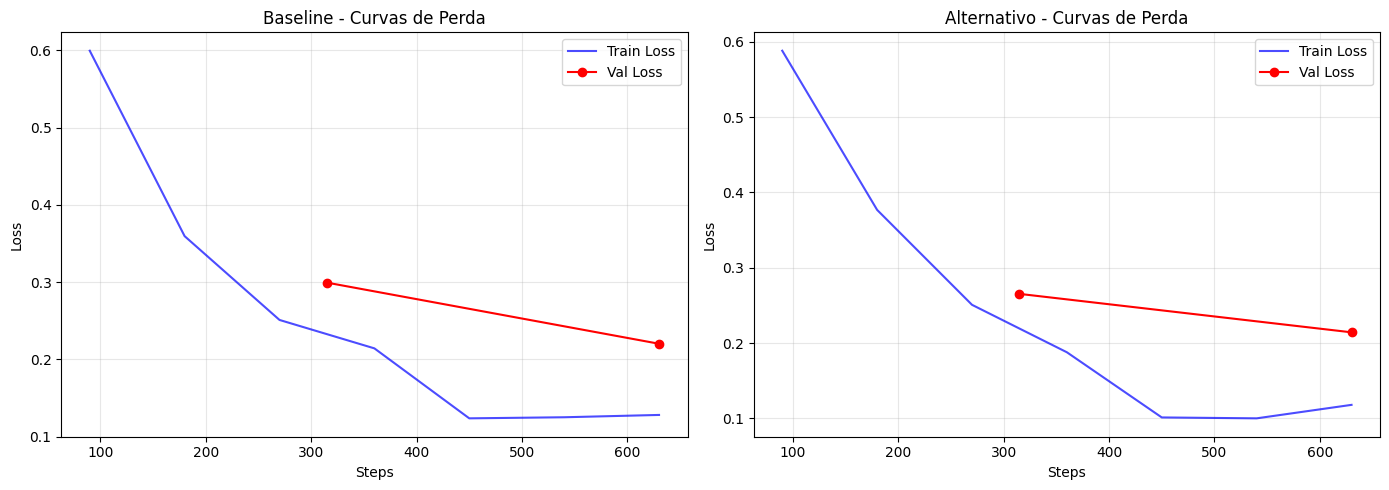

In [41]:


fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Baseline
steps, losses = zip(*baseline_train)
axes[0].plot(steps, losses, label='Train Loss', color='blue', alpha=0.7)
epochs, eval_losses, _ = zip(*baseline_eval)
# Interpola eval loss nos steps correspondentes
eval_steps = [steps[-1] * e / max(epochs) for e in epochs]
axes[0].plot(eval_steps, eval_losses, label='Val Loss', color='red', marker='o')
axes[0].set_title('Baseline - Curvas de Perda')
axes[0].set_xlabel('Steps')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Alternativo
steps, losses = zip(*alt_train)
axes[1].plot(steps, losses, label='Train Loss', color='blue', alpha=0.7)
epochs, eval_losses, _ = zip(*alt_eval)
eval_steps = [steps[-1] * e / max(epochs) for e in epochs]
axes[1].plot(eval_steps, eval_losses, label='Val Loss', color='red', marker='o')
axes[1].set_title('Alternativo - Curvas de Perda')
axes[1].set_xlabel('Steps')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(root, 'documents', 'curvas_perda.png'), dpi=300)
plt.show()



#### 3. Confusion Matrix

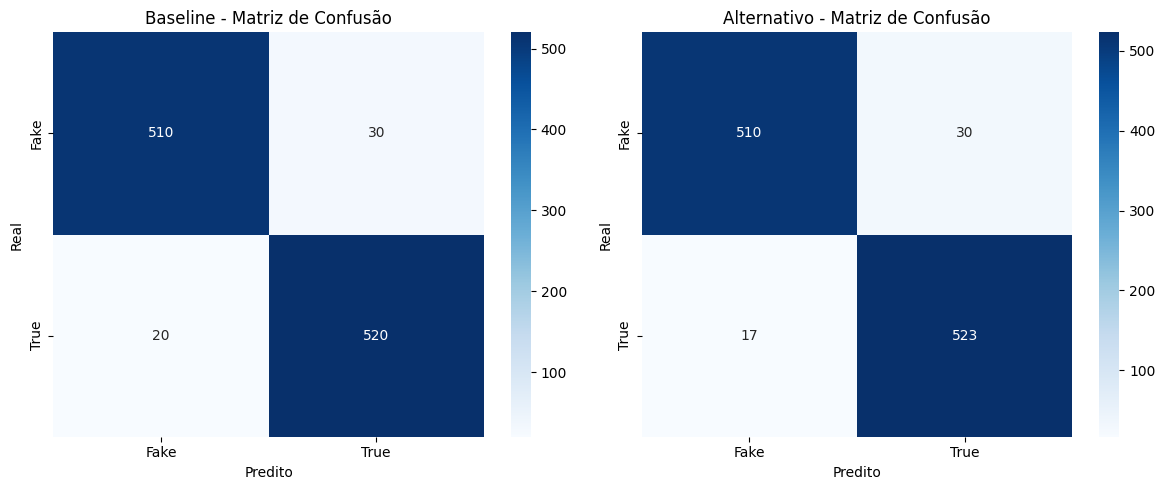

In [42]:

# Usa as predições já feitas (baseline_predictions e alternative_predictions)
y_true_base = baseline_predictions.label_ids
y_pred_base = np.argmax(baseline_predictions.predictions, axis=1)

y_true_alt = alternative_predictions.label_ids
y_pred_alt = np.argmax(alternative_predictions.predictions, axis=1)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

cm_base = confusion_matrix(y_true_base, y_pred_base)
sns.heatmap(cm_base, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['Fake', 'True'], yticklabels=['Fake', 'True'])
axes[0].set_title('Baseline - Matriz de Confusão')
axes[0].set_xlabel('Predito')
axes[0].set_ylabel('Real')

cm_alt = confusion_matrix(y_true_alt, y_pred_alt)
sns.heatmap(cm_alt, annot=True, fmt='d', cmap='Blues', ax=axes[1],
            xticklabels=['Fake', 'True'], yticklabels=['Fake', 'True'])
axes[1].set_title('Alternativo - Matriz de Confusão')
axes[1].set_xlabel('Predito')
axes[1].set_ylabel('Real')

plt.tight_layout()
plt.savefig(os.path.join(root, 'documents', 'matrizes_confusao.png'), dpi=300)
plt.show()


#### 4. Comparando Métricas

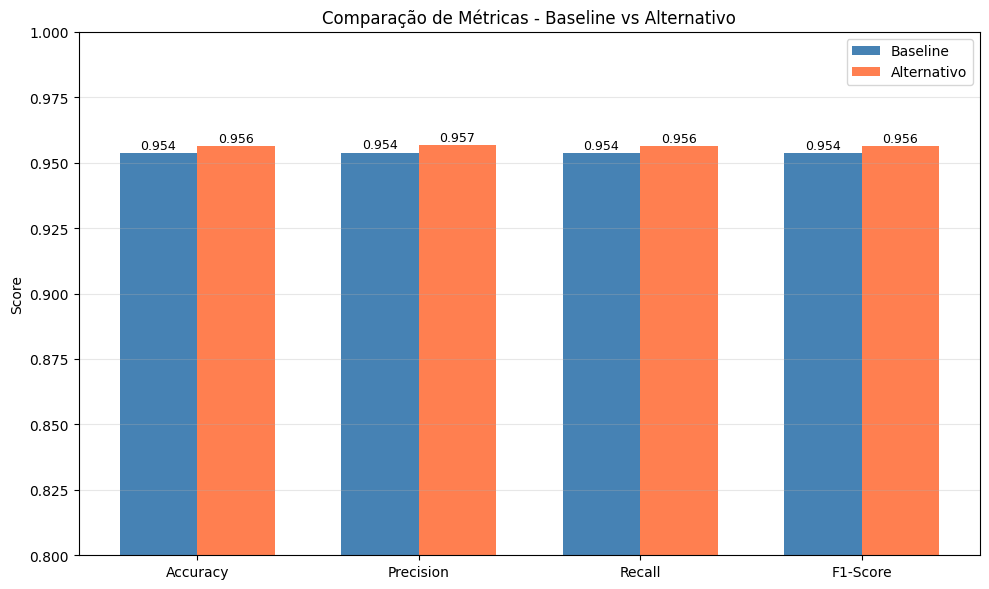


RESUMO COMPARATIVO
  Métrica  Baseline  Alternativo
 Accuracy  0.953704     0.956481
Precision  0.953859     0.956746
   Recall  0.953704     0.956481
 F1-Score  0.953700     0.956475

Diferença (Alternativo - Baseline):
  Accuracy: +0.0028
  Precision: +0.0029
  Recall: +0.0028
  F1-Score: +0.0028


In [ ]:

metrics_df = pd.DataFrame({
    'Métrica': ['Accuracy', 'Precision', 'Recall', 'F1-Score'],
    'Baseline': [
        baseline_predictions.metrics['test_accuracy'],
        baseline_predictions.metrics['test_precision'],
        baseline_predictions.metrics['test_recall'],
        baseline_predictions.metrics['test_f1']
    ],
    'Alternativo': [
        alternative_predictions.metrics['test_accuracy'],
        alternative_predictions.metrics['test_precision'],
        alternative_predictions.metrics['test_recall'],
        alternative_predictions.metrics['test_f1']
    ]
})

# Plot
x = np.arange(len(metrics_df))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(x - width/2, metrics_df['Baseline'], width, label='Baseline', color='steelblue')
bars2 = ax.bar(x + width/2, metrics_df['Alternativo'], width, label='Alternativo', color='coral')

ax.set_ylabel('Score')
ax.set_title('Comparação de Métricas - Baseline vs Alternativo')
ax.set_xticks(x)
ax.set_xticklabels(metrics_df['Métrica'])
ax.legend()
ax.set_ylim(0.9, 1)
ax.grid(axis='y', alpha=0.3)

# Anota valres
for bar in bars1 + bars2:
    height = bar.get_height()
    ax.annotate(f'{height:.3f}',
                xy=(bar.get_x() + bar.get_width()/2, height),
                xytext=(0, 3), textcoords="offset points",
                ha='center', fontsize=9)

plt.tight_layout()
plt.savefig(os.path.join(root, 'documents', 'comparacao_metricas.png'), dpi=300)
plt.show()

print("\n" + "="*60)
print("RESUMO COMPARATIVO")
print("="*60)
print(metrics_df.to_string(index=False))
print("\nDiferença (Alternativo - Baseline):")
for metric in ['Accuracy', 'Precision', 'Recall', 'F1-Score']:
    diff = metrics_df[metrics_df['Métrica'] == metric]['Alternativo'].values[0] - \
           metrics_df[metrics_df['Métrica'] == metric]['Baseline'].values[0]
    print(f"  {metric}: {diff:+.4f}")


#### 5. Analise Qualitativa

In [44]:

# Pega índices acertos e erros
base_correct = np.where(y_pred_base == y_true_base)[0]
base_wrong = np.where(y_pred_base != y_true_base)[0]

alt_correct = np.where(y_pred_alt == y_true_alt)[0]
alt_wrong = np.where(y_pred_alt != y_true_alt)[0]

print("\n" + "="*60)
print("ANÁLISE QUALITATIVA")
print("="*60)

# Mostra 3 exemplos de cada
print("\n--- BASELINE: Acertos ---")
for idx in np.random.choice(base_correct, min(3, len(base_correct)), replace=False):
    print(f"Real: {y_true_base[idx]} | Pred: {y_pred_base[idx]}")
    print(f"Confiança: {baseline_predictions.predictions[idx].max():.3f}\n")

print("\n--- BASELINE: Erros ---")
for idx in np.random.choice(base_wrong, min(3, len(base_wrong)), replace=False):
    print(f"Real: {y_true_base[idx]} | Pred: {y_pred_base[idx]}")
    print(f"Confiança: {baseline_predictions.predictions[idx].max():.3f}\n")




ANÁLISE QUALITATIVA

--- BASELINE: Acertos ---
Real: 1 | Pred: 1
Confiança: 3.049

Real: 0 | Pred: 0
Confiança: 3.726

Real: 1 | Pred: 1
Confiança: 3.200


--- BASELINE: Erros ---
Real: 0 | Pred: 1
Confiança: 1.563

Real: 1 | Pred: 0
Confiança: 1.206

Real: 0 | Pred: 1
Confiança: 1.338



#### 6. bônus: t-sne dos embeddings

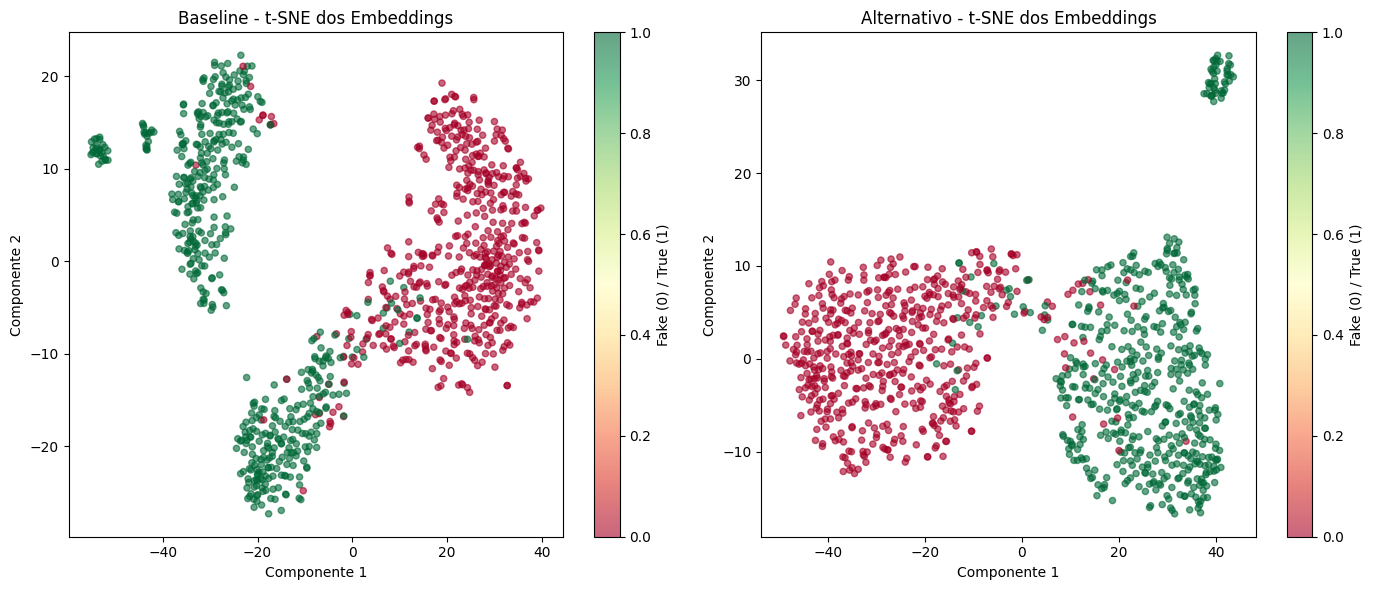

In [ ]:

def extract_embeddings(model, test_loader, pooling='cls'):
    """Extrai embeddings do modelo"""
    model.eval()
    embeddings, labels = [], []
    
    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(cfg.DEVICE)
            attention_mask = batch['attention_mask'].to(cfg.DEVICE)
            
            # Para baseline
            if hasattr(model, 'bert'):
                outputs = model.bert(input_ids=input_ids, attention_mask=attention_mask)
                last_hidden = outputs.last_hidden_state
                
                if pooling == 'cls':
                    emb = last_hidden[:, 0, :]
                elif pooling == 'concat':
                    # print('chegou aqui')
                    cls_emb = last_hidden[:, 0, :]
                    mask_exp = attention_mask.unsqueeze(-1).expand(last_hidden.size()).float()
                    mean_emb = (last_hidden * mask_exp).sum(dim=1) / mask_exp.sum(dim=1).clamp(min=1e-9)
                    emb = torch.cat([cls_emb, mean_emb], dim=1)
            
            embeddings.append(emb.cpu().numpy())
            labels.extend(batch['labels'].numpy())
    
    return np.vstack(embeddings), np.array(labels)

# Cria DataLoader para extração
from torch.utils.data import DataLoader
test_loader = DataLoader(test_dataset, batch_size=16)

# Extrai embeddings
base_embeddings, base_labels = extract_embeddings(baseline_model, test_loader, pooling='cls')
alt_embeddings, alt_labels = extract_embeddings(alt_model, test_loader, pooling='concat')

# t-SNE
tsne = TSNE(n_components=2, random_state=cfg.RANDOM_SEED, perplexity=30)

base_2d = tsne.fit_transform(base_embeddings)
alt_2d = tsne.fit_transform(alt_embeddings)

# Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

scatter1 = axes[0].scatter(base_2d[:, 0], base_2d[:, 1], 
                           c=base_labels, cmap='RdYlGn', alpha=0.6, s=20)
axes[0].set_title('Baseline - t-SNE dos Embeddings')
axes[0].set_xlabel('Componente 1')
axes[0].set_ylabel('Componente 2')
plt.colorbar(scatter1, ax=axes[0], label='Fake (0) / True (1)')

scatter2 = axes[1].scatter(alt_2d[:, 0], alt_2d[:, 1], 
                           c=alt_labels, cmap='RdYlGn', alpha=0.6, s=20)
axes[1].set_title('Alternativo - t-SNE dos Embeddings')
axes[1].set_xlabel('Componente 1')
axes[1].set_ylabel('Componente 2')
plt.colorbar(scatter2, ax=axes[1], label='Fake (0) / True (1)')

plt.tight_layout()
plt.savefig(os.path.join(root, 'documents', 'tsne_embeddings.png'), dpi=300)
plt.show()



#### 7. Save Final

In [46]:

# Salva métricas em JSON
results = {
    'baseline': baseline_predictions.metrics,
    'alternativo': alternative_predictions.metrics,
    'comparacao': metrics_df.to_dict()
}

with open(os.path.join(root, 'documents', 'resultados_finais.json'), 'w') as f:
    json.dump(results, f, indent=2)

print("\n✅ Todas as visualizações salvas em /documents/")


✅ Todas as visualizações salvas em /documents/
